In [1]:
import os
import sys
import xarray as xr
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, date
from pathlib import Path
import cartopy.crs as ccrs
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def coordinates_processors(data):
    """
    converting longitude/latitude into lon/lat
    """
    coord_names = []
    for coord_name in data.coords:
        coord_names.append(coord_name)

    if (set(coord_names) & set(['longitude','latitude'])): # if coordinates set this way...
        data2 = data.rename({'latitude': 'lat'})
        data2 = data2.rename({'longitude': 'lon'})
    else:
        data2 = data

    # check if latitutde is decreasing
    if (data2.lat[1] - data2.lat[0]) < 0:
        data2 = data2.reindex(lat=list(reversed(data2.lat))) # flipping latitude accoordingly

    # check if longitude is -180 to 180
    # if so, reconstructing into 0 to 360
    if (data2.lon.min() < 0):
        data2['lon'] = xr.where(data2['lon'] < 0, data2['lon'] + 360, data2['lon'])
        data2 = data2.sortby('lon')

    return data2

In [5]:
##### fixed parameters. do not change ######
PFID_catalog = {'AR':1, 'FT':2, 'MCS': 3, 'LPS': 4,
                'AR-FT': 5, 'AR-MCS': 6, 'AR-LPS': 7,
                'FT-MCS': 8,' FT-LPS': 9, 'MCS-LPS': 10,
                'AR-FT-MCS': 11, 'AR-FT-LPS': 12, 'AR-MCS-LPS': 13,
                'FT-MCS-LPS': 14, 'AR-FT-MCS-LPS': 15,
                'Unexp': 16,
                'DC': 17, 'ND': 18, 'ST': 19, 'DZ': 20}
###############

In [12]:
%%time
year = 2014

for month in range(1,2):
    print('Month: {}'.format(month))
    
    pid_dir = Path('/scratch/wmtsai/GPM_feature_precip/{}/'.format(year))
    # merge all tracks into a single xarray.dataset file 
    ds_PFID = coordinates_processors(xr.open_dataset(pid_dir / 'GPM-IMERG_feature_precip_{}_{}.nc'.format(year,str(month).zfill(2))))
    precip_id = ds_PFID.precip_id
    feat_mask = xr.open_dataset(pid_dir / 'GPM_feature_merged_{}_v4.nc'.format(str(month).zfill(2)))
    prec_gpm = coordinates_processors(feat_mask.precipitationCal).sel(lon=slice(0,359.75))

    era5_dir = Path('/neelin2020/ERA-5/NC_FILES/{}/'.format(year))
    mse_dir = Path('/neelin2020/ERA-5_mse/{}/'.format(year))
    omega_dir = Path('/scratch/wmtsai/ERA-5/NC_FILES/{}'.format(year))
    ds_q = coordinates_processors(xr.open_dataset(era5_dir / 'era-5.q.{}.{}.nc'.format(year,str(month).zfill(2)))).sel(lat=slice(-60,60))
    ds_T = coordinates_processors(xr.open_dataset(era5_dir / 'era-5.T.{}.{}.nc'.format(year,str(month).zfill(2)))).sel(lat=slice(-60,60))
    ds_w = coordinates_processors(xr.open_dataset(era5_dir / 'era-5.omega.{}.{}.nc'.format(year,str(month).zfill(2)))).sel(lat=slice(-60,60))
    ds_mse = coordinates_processors(xr.open_dataset(mse_dir / 'ERA-5.mse.{}.{}.nc'.format(year,str(month).zfill(2)))).sel(lat=slice(-60,60))
    ds_mseinst = ds_mse.mse_850 - ds_mse.mse_sat_500

    target_PFIDs = ['AR','FT','AR-FT','AR-FT-MCS','MCS','LPS','MCS-LPS','DC','ND']
    cwv_bins = np.linspace(0,70,36)
    w500_bins = np.linspace(-2,2,41)
    w850_bins = np.linspace(-2,2,41)
    mseinst_bins = np.linspace(-20,10,31)

    samples_cwv = np.zeros((2, len(target_PFIDs), len(cwv_bins)-1)) # (region_id (T,ET), precip_id, bins)
    samples_w500 = np.zeros((2, len(target_PFIDs), len(w500_bins)-1))
    samples_w850 = np.zeros((2, len(target_PFIDs), len(w850_bins)-1))
    samples_mseinst = np.zeros((2, len(target_PFIDs), len(mseinst_bins)-1)) 

    for n,pfid in enumerate(target_PFIDs):

        pfid_number = PFID_catalog[pfid]
        print('PF identifier: {}, number: {}'.format(pfid, pfid_number))

        for t in range(len(precip_id.time)):

            pfid_2dmap = precip_id.isel(time=t)
            # sampling the associated grids for extracting environmental factors
            q_2dmap = (ds_q.q.isel(time=t)).where(pfid_2dmap == pfid_number)
            cwv_2dmap = (100/9.8)*q_2dmap.integrate('level')
            w500_2dmap = (ds_w.w.isel(time=t).sel(level=500)).where(pfid_2dmap == pfid_number)
            w850_2dmap = (ds_w.w.isel(time=t).sel(level=850)).where(pfid_2dmap == pfid_number)
            mseinst_2dmap = ds_mseinst.isel(time=t).where(pfid_2dmap == pfid_number)

            # 1. tropical values
            (counts_cwv, bin_edge) = np.histogram(cwv_2dmap.sel(lat=slice(-30,30)), bins=cwv_bins)
            (counts_mseinst, bin_edge) = np.histogram(mseinst_2dmap.sel(lat=slice(-30,30)), bins=mseinst_bins)
            (counts_w500, bin_edge) = np.histogram(w500_2dmap.sel(lat=slice(-30,30)), bins=w500_bins)
            (counts_w850, bin_edge) = np.histogram(w850_2dmap.sel(lat=slice(-30,30)), bins=w850_bins)
            samples_cwv[0,n,:] += counts_cwv
            samples_mseinst[0,n,:] += counts_mseinst
            samples_w500[0,n,:] += counts_w500
            samples_w850[0,n,:] += counts_w850

            # 2. extra-tropical values
            (counts_cwv, bin_edge) = np.histogram(cwv_2dmap.sel(lat=slice(30,60)), bins=cwv_bins)
            (counts_mseinst, bin_edge) = np.histogram(mseinst_2dmap.sel(lat=slice(30,60)), bins=mseinst_bins)
            (counts_w500, bin_edge) = np.histogram(w500_2dmap.sel(lat=slice(30,60)), bins=w500_bins)
            (counts_w850, bin_edge) = np.histogram(w850_2dmap.sel(lat=slice(30,60)), bins=w850_bins)
            # tropical values
            samples_cwv[1,n,:] += counts_cwv
            samples_mseinst[1,n,:] += counts_mseinst
            samples_w500[1,n,:] += counts_w500
            samples_w850[1,n,:] += counts_w850
        
# construct as xarray dataset
ds_bins_cwv = xr.Dataset(data_vars = dict(samples = (['region','precip_id','bins'], samples_cwv)), 
                    coords = dict(bins = (['bins'], cwv_bins[:-1]),
                                  precip_id = (['precip_id'], target_PFIDs),
                                  region = (['region'], ['tropics','extratropics']))
                                  )
ds_bins_mseinst = xr.Dataset(data_vars = dict(samples = (['region','precip_id','bins'], samples_mseinst)), 
                    coords = dict(bins = (['bins'], mseinst_bins[:-1]),
                                  precip_id = (['precip_id'], target_PFIDs),
                                  region = (['region'], ['tropics','extratropics']))
                                  )
ds_bins_w500 = xr.Dataset(data_vars = dict(samples = (['region','precip_id','bins'], samples_w500)), 
                    coords = dict(bins = (['bins'], w500_bins[:-1]),
                                  precip_id = (['precip_id'], target_PFIDs),
                                  region = (['region'], ['tropics','extratropics']))
                                  )
ds_bins_w850 = xr.Dataset(data_vars = dict(samples = (['region','precip_id','bins'], samples_w850)), 
                    coords = dict(bins = (['bins'], w850_bins[:-1]),
                                  precip_id = (['precip_id'], target_PFIDs),
                                  region = (['region'], ['tropics','extratropics']))
                                  )

Month: 1
PF identifier: AR, number: 1
PF identifier: FT, number: 2
PF identifier: AR-FT, number: 5
PF identifier: AR-FT-MCS, number: 11
PF identifier: MCS, number: 3
PF identifier: LPS, number: 4
PF identifier: MCS-LPS, number: 10
PF identifier: DC, number: 17
PF identifier: ND, number: 18
CPU times: user 3min 54s, sys: 3min 28s, total: 7min 23s
Wall time: 8min 44s


Text(0, 0.5, 'Latitude')

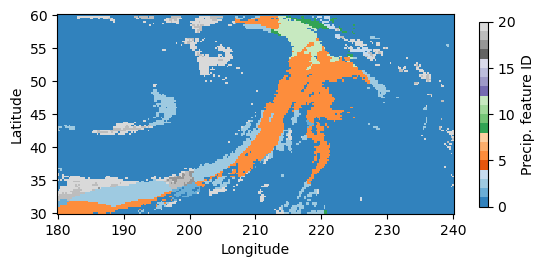

In [51]:
fig, ax = plt.subplots(1,1)
tmp = precip_id.isel(time=0).sel(lon=slice(180,240),lat=slice(30,60))
cp = plt.pcolormesh(tmp.lon, tmp.lat, tmp,cmap='tab20c')
ax.set_aspect('equal')
cbar = plt.colorbar(cp, shrink=0.5)
cbar.set_label('Precip. feature ID')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [11]:
# # save datasets 
# ds_bins_cwv.to_netcdf('/scratch/wmtsai/featenv_analysis/analysis/featenv_cwv_histogram.2014.nc')
# ds_bins_mseinst.to_netcdf('/scratch/wmtsai/featenv_analysis/analysis/featenv_mseinst_histogram.2014.nc')
# ds_bins_w850.to_netcdf('/scratch/wmtsai/featenv_analysis/analysis/featenv_w850_histogram.2014.nc')
# ds_bins_w500.to_netcdf('/scratch/wmtsai/featenv_analysis/analysis/featenv_w500_histpgram.2014.nc')

In [13]:
pdf_cwv = (ds_bins_cwv/ds_bins_cwv.sum('bins'))
pdf_mseinst = (ds_bins_mseinst/ds_bins_mseinst.sum('bins'))
pdf_w500 = (ds_bins_w500/ds_bins_w500.sum('bins'))
pdf_w850 = (ds_bins_w850/ds_bins_w850.sum('bins'))

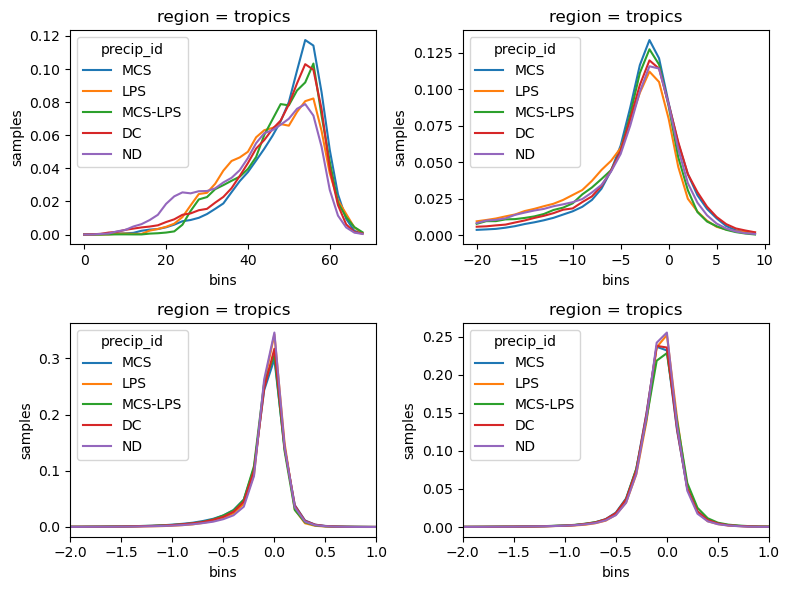

In [14]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,6))

pdf_cwv.sel(precip_id=['MCS','LPS','MCS-LPS','DC','ND'],region='tropics').samples.plot(ax=ax1,x='bins',hue='precip_id')
pdf_mseinst.sel(precip_id=['MCS','LPS','MCS-LPS','DC','ND'],region='tropics').samples.plot(ax=ax2,x='bins',hue='precip_id')
pdf_w500.sel(precip_id=['MCS','LPS','MCS-LPS','DC','ND'],region='tropics').samples.plot(ax=ax3,x='bins',hue='precip_id')
pdf_w850.sel(precip_id=['MCS','LPS','MCS-LPS','DC','ND'],region='tropics').samples.plot(ax=ax4,x='bins',hue='precip_id')

ax3.set_xlim([-2,1])
ax4.set_xlim([-2,1])
plt.tight_layout()
plt.show()

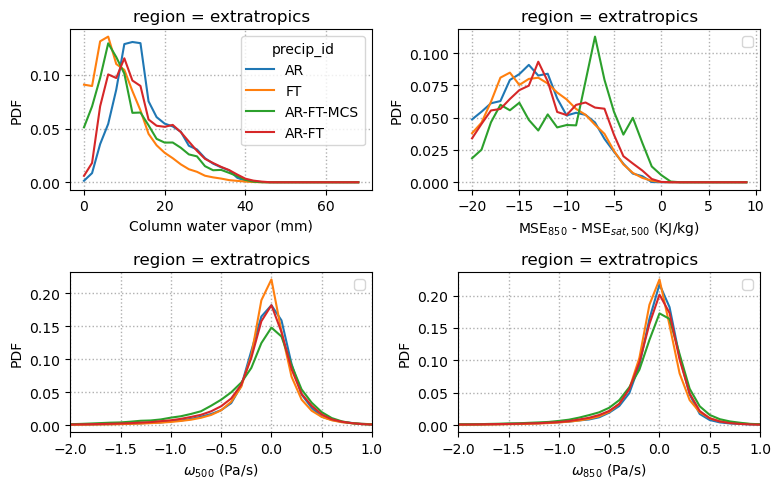

In [29]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,5))

pdf_cwv.sel(precip_id=['AR','FT','AR-FT-MCS','AR-FT'],region='extratropics').samples.plot(ax=ax1,x='bins',hue='precip_id')
pdf_mseinst.sel(precip_id=['AR','FT','AR-FT-MCS','AR-FT'],region='extratropics').samples.plot(ax=ax2,x='bins',hue='precip_id')
pdf_w500.sel(precip_id=['AR','FT','AR-FT-MCS','AR-FT'],region='extratropics').samples.plot(ax=ax3,x='bins',hue='precip_id')
pdf_w850.sel(precip_id=['AR','FT','AR-FT-MCS','AR-FT'],region='extratropics').samples.plot(ax=ax4,x='bins',hue='precip_id')

ax3.set_xlim([-2,1])
ax4.set_xlim([-2,1])
ax1.set_ylabel('PDF')
ax2.set_ylabel('PDF')
ax3.set_ylabel('PDF')
ax4.set_ylabel('PDF')
ax1.set_xlabel('Column water vapor (mm)')
ax2.set_xlabel('MSE$_{850}$ - MSE$_{sat,500}$ (KJ/kg)')
ax3.set_xlabel('$\omega$$_{500}$ (Pa/s)')
ax4.set_xlabel('$\omega$$_{850}$ (Pa/s)')
ax2.legend('')
ax3.legend('')
ax4.legend('')
for ax in [ax1,ax2,ax3,ax4]:
    ax.grid(lw=1, ls=':')

plt.tight_layout()
plt.show()